<a href="https://colab.research.google.com/github/AnnaKholkina/rl_guu/blob/main/rl_transport_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
#from tensorboardX import SummaryWriter
HIDDEN_SIZE = 128
BATCH_SIZE = 16
PERCENTILE = 50

import warnings
import operator
import random
warnings.filterwarnings("ignore")

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size=128, out_size1=4, out_size2=2):
        super(SimpleNet, self).__init__()
        self.linear_common = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU() 
        )
        self.linear1 = nn.Sequential(
            nn.Linear(hidden_size, out_size1),
            nn.ReLU() 
        )

        self.linear2 = nn.Sequential(
            nn.Linear(hidden_size, out_size2),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.linear_common(x)
        return self.linear1(x), self.linear2(x)

In [ ]:
class Episode:
    def __init__(self):
        self.total_reward = 0
        self.observations = []
        self.actions = []

### Задача

Для начала я решила попробовать решить простую задачу: имеется один поставщик, у которого есть 80 единиц продукции (изначально они равномерно распределены между заказчиками, массив trans) и 4 заказчика (customers). Массив цен, по которым поставщик продает каждому заказчику называется costs. Задача поставщика распределить товары таким образом, чтобы получить от этого максимальную прибыль.

В дальнейшем эту задачу можно инвертировать и привести к задаче минимизации затрат на транспортировку, но пока что я решила решать максимизацию, которая заложена в классической постановке задачи обучения с подкреплением.

In [ ]:
customers = np.array([75, 80, 60, 85])
trans = np.array([20, 20, 20, 20])
costs = np.array([6, 7, 3, 5])

In [ ]:
trans * costs

array([120, 140,  60, 100])

In [ ]:
np.sum(trans * costs)

420

In [ ]:
net = SimpleNet(input_size=4)
x = torch.tensor(trans, dtype=torch.float)
ind, act = net(x)

In [ ]:
ind

tensor([0.0000, 3.4178, 0.0000, 0.0000], grad_fn=<ReluBackward0>)

In [ ]:
act

tensor([3.3498, 0.0000], grad_fn=<ReluBackward0>)

### Как работает нейросеть

На вход она получает массив текущего состояния стоимости продажи продукции (trans * costs). Мне показалось это более разумно, так нейросеть будет понимать сколько мы зарабатываем, а не просто непонятные числа из trans (изначально в экспериментах я давала ей просто trans, как в этом маленьком примере, но ничего хорошего из этого не вышло). На выходе мы имеем массив той же размерности, по аргмаксу которого определяется индекс, элемент которого мы будем менять. Я немного модифицировала Вашу нейросеть и подавала на linear2 слой linear1. Как бы из информации о том, какой элемент будет изменяться, принимать решение прибавлять к нему 1 или убавлять.

К слову, были также эксперименты с Вашей архитектурой, тоже провалились.

In [ ]:
ind

tensor([4.7994, 0.0000, 0.0000, 0.0000], grad_fn=<ReluBackward0>)

In [ ]:
act

tensor([1.7350, 1.7502], grad_fn=<ReluBackward0>)

In [ ]:
torch.argmax(ind)

tensor(1)

### Как делается шаг

Первый атпут нейросети выдает позицию, с которой нужно произвести действие. Второй атпут определяет какое действие - убавить на 1 или прибавить на 1. Также я попробовала ввести ограничения транспортной задачи, поэтому при увеличении одного элемента, другой рандомный уменьшается и наоборот.

In [ ]:
def step(t, position, action, limit=200):
  random_pos_list = [0, 1, 2, 3]
  random_pos_list.remove(position)
  random_el = random.choice(random_pos_list)
  if action == 0 and t[position] > 0 and t[position] <= customers[position] and torch.sum(t) <= limit:
  #if action == 0:
    t[position] -= 1
    t[random_el] += 1
  if action == 1 and t[position] <= customers[position] and t[random_el] > 0 and torch.sum(t) <= limit:
  #if action == 1:
    t[position] += 1
    t[random_el] -= 1

  return torch.tensor(t, dtype=torch.float)

In [ ]:
def reward(trans, costs):
  assert trans.shape == costs.shape, 'Проверить размерности таблиц'

  reward = 0
  for i in range(len(trans)):
      reward += trans[i]*costs[i]
  
  return reward

In [ ]:
def episode_batch_generator(table, model, batch_size, num_episodes, show_prints=False):
  episodes = []
  start_obs = torch.tensor(table, dtype=torch.float)
  obs = start_obs.clone().detach() # копирую изначальное состояние
  episode = Episode()
  softmax = nn.Softmax()

  for ep in range(num_episodes): # я не придумала, как сделать подобие done в картполе, поэтому просто генерирую несколько эпизодов с длиной батча
    for itr in range(batch_size):
      costs_obs = torch.tensor(obs * costs, dtype=torch.float)
      indexes_val, actions_val = model(costs_obs)

      indexes_prob = softmax(indexes_val)
      indexes_prob = indexes_prob.data.numpy()
      index = np.random.choice(4, p=indexes_prob) # выбираю индекс, элемент которого будет изменен

      actions_prob = softmax(actions_val)
      actions_prob = actions_prob.data.numpy()
      action = np.random.choice(2, p=actions_prob) # выбираю действие

      next_obs = step(obs, index, action)
      r = reward(next_obs, costs)
      if show_prints:
        print(f'Itr: {itr}')
        print(f'Index: {index}, action: {action}')
        print(next_obs)
        print(r)

      episode.total_reward += r
      episode.observations.append(obs)
      episode.actions.append(action)
      obs = next_obs

    episodes.append(episode)
    if show_prints:
      print(f'Results of episode: total_reward - {episode.total_reward}')
    episode = Episode()
    obs = start_obs.clone().detach()
    if show_prints:
      print(f'End episode {ep}, start_obs = {obs}')
  
  return episodes

В этой функции не учитываются индексы, но ниже есть вторая реализация, где помимо действия сравниваются еще и индексы.

In [ ]:
def filter_elite_episodes(batch, min_reward_percentice):
    actions, observations = [], []
    rewards = list(map(lambda e: e.total_reward, batch))
    reward_boundary = np.percentile(rewards, min_reward_percentice)
    for episode in batch:
        if episode.total_reward < reward_boundary:
          continue

        observations.extend(episode.observations)
        actions.extend(episode.actions)
    mean_rewards = np.mean(rewards)

    return torch.stack(observations), torch.FloatTensor(actions), mean_rewards

In [ ]:
b = episode_batch_generator(trans, net, 16, 1, show_prints=True)

Itr: 0
Index: 1, action: 0
tensor([20., 19., 21., 20.])
tensor(416.)
Itr: 1
Index: 1, action: 0
tensor([20., 18., 22., 20.])
tensor(412.)
Itr: 2
Index: 1, action: 0
tensor([20., 17., 22., 21.])
tensor(410.)
Itr: 3
Index: 1, action: 0
tensor([20., 16., 22., 22.])
tensor(408.)
Itr: 4
Index: 1, action: 0
tensor([20., 15., 22., 23.])
tensor(406.)
Itr: 5
Index: 1, action: 0
tensor([21., 14., 22., 23.])
tensor(405.)
Itr: 6
Index: 1, action: 0
tensor([22., 13., 22., 23.])
tensor(404.)
Itr: 7
Index: 1, action: 0
tensor([22., 12., 22., 24.])
tensor(402.)
Itr: 8
Index: 1, action: 0
tensor([23., 11., 22., 24.])
tensor(401.)
Itr: 9
Index: 1, action: 0
tensor([23., 10., 23., 24.])
tensor(397.)
Itr: 10
Index: 1, action: 0
tensor([24.,  9., 23., 24.])
tensor(396.)
Itr: 11
Index: 1, action: 0
tensor([24.,  8., 23., 25.])
tensor(394.)
Itr: 12
Index: 1, action: 0
tensor([24.,  7., 23., 26.])
tensor(392.)
Itr: 13
Index: 1, action: 0
tensor([25.,  6., 23., 26.])
tensor(391.)
Itr: 14
Index: 1, action: 1
te

In [ ]:
filter_elite_episodes(b, 90)

(tensor([[20., 19., 21., 20.],
         [20., 18., 22., 20.],
         [20., 17., 22., 21.],
         [20., 16., 22., 22.],
         [20., 15., 22., 23.],
         [21., 14., 22., 23.],
         [22., 13., 22., 23.],
         [22., 12., 22., 24.],
         [23., 11., 22., 24.],
         [23., 10., 23., 24.],
         [24.,  9., 23., 24.],
         [24.,  8., 23., 25.],
         [24.,  7., 23., 26.],
         [25.,  6., 23., 26.],
         [24.,  7., 23., 26.],
         [25.,  6., 23., 26.]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 6417.0)

In [ ]:
def train(table, batch_size, num_episodes):
  model = SimpleNet(input_size=4)
  optimizer = optim.Adam(model.parameters(), lr=0.01)
  loss_fn = nn.CrossEntropyLoss()
  softmax = nn.Softmax(dim=1)
  losses = []
  for iter in range(100):
    b = episode_batch_generator(table, model, batch_size, num_episodes)
    observations, target_actions, mean_rewards = filter_elite_episodes(b, 90)
    optimizer.zero_grad()
    indexes_val, actions_val = model(observations)
    index = torch.argmax(indexes_val, dim=1, keepdim=False)
    pred_actions = torch.argmax(actions_val, dim=1, keepdim=False)
    loss = loss_fn(torch.tensor(pred_actions, dtype=torch.float, requires_grad=True), target_actions)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    print(f'\rItr:{iter}, loss :{loss}, mean reward: {mean_rewards}', end='')

  return losses

In [ ]:
losses = train(trans, 10, 10)

Itr:99, loss :23.025854110717773, mean reward: 4025.89990234375

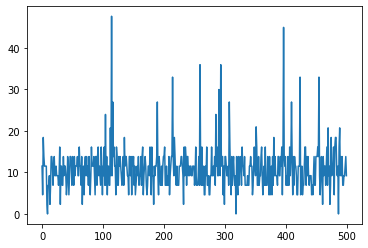

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

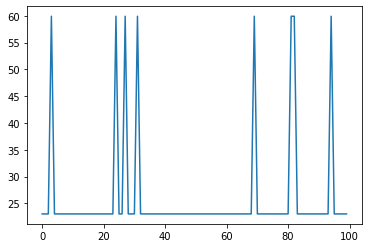

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

### Это был, наверное, уже сотый эксперимент, но лосс никогда не вел себя как нужно. В некоторых случаях достигался хороший reward, но это была рандомная перестановка до тех пор, пока не достигнется нужное значение.

### 2 подход. Смотрим и на индекс, и на действие

In [ ]:
class Episode:
    def __init__(self):
        self.total_reward = 0
        self.observations = []
        self.actions = []
        self.indexes = []

In [ ]:
def episode_batch_generator(table, model, batch_size, num_episodes, show_prints=False):
  batch = []
  start_obs = torch.tensor(table, dtype=torch.float)
  obs = start_obs.clone().detach() # копирую изначальное состояние
  episode = Episode()
  softmax = nn.Softmax()

  for ep in range(num_episodes):
    for itr in range(batch_size):
      costs_obs = torch.tensor(obs * costs, dtype=torch.float)
      indexes_val, actions_val = model(costs_obs)

      indexes_prob = softmax(indexes_val)
      indexes_prob = indexes_prob.data.numpy()
      index = np.random.choice(4, p=indexes_prob)

      actions_prob = softmax(actions_val)
      actions_prob = actions_prob.data.numpy()
      action = np.random.choice(2, p=actions_prob)

      next_obs = step(obs, index, action)
      r = reward(next_obs, costs)
      if show_prints:
        print(f'Itr: {itr}')
        print(f'Index: {index}, action: {action}')
        print(next_obs)
        print(r)

      episode.total_reward += r
      episode.observations.append(obs)
      episode.actions.append(action)
      episode.indexes.append(index)
      obs = next_obs

    batch.append(episode)
    if show_prints:
      print(f'Results of episode: total_reward - {episode.total_reward}')
    episode = Episode()
    obs = start_obs.clone().detach()
    if show_prints:
      print(f'End episode {ep}, start_obs = {obs}')
  
  return batch

In [ ]:
def filter_elite_episodes(batch, min_reward_percentice):
    actions, indexes, observations = [], [], []
    rewards = list(map(lambda e: e.total_reward, batch))
    reward_boundary = np.percentile(rewards, min_reward_percentice)
    for episode in batch:
        if episode.total_reward < reward_boundary:
          continue

        observations.extend(episode.observations)
        actions.extend(episode.actions)
        indexes.extend(episode.indexes)
    mean_rewards = np.mean(rewards)

    return torch.stack(observations), torch.FloatTensor(actions), torch.FloatTensor(indexes), mean_rewards

In [ ]:
def train(table, batch_size, num_episodes):
  model = SimpleNet(input_size=4)
  optimizer = optim.Adam(model.parameters(), lr=0.01)
  loss_fn_ind = nn.CrossEntropyLoss()
  loss_fn_act = nn.CrossEntropyLoss()
  softmax = nn.Softmax(dim=1)
  losses = []
  for iter in range(103):
    b = episode_batch_generator(table, model, batch_size, num_episodes)
    observations, target_actions, target_indexes, mean_rewards = filter_elite_episodes(b, 90)
    optimizer.zero_grad()
    indexes_val, actions_val = model(observations)
    pred_indexes = torch.argmax(indexes_val, dim=1, keepdim=False)
    pred_actions = torch.argmax(actions_val, dim=1, keepdim=False)

    # print('Epoch:', iter)
    # print(observations)
    # print(indexes_val)
    # print('Pred actions', torch.tensor(pred_actions, dtype=torch.float, requires_grad=True))
    # print('Pred indexes', torch.tensor(pred_indexes, dtype=torch.float, requires_grad=True))
    # print('Target actions', target_actions)
    # print('Target indexes', target_indexes)

    loss_act = loss_fn_act(torch.tensor(pred_actions, dtype=torch.float, requires_grad=True), target_actions)
    loss_ind = loss_fn_ind(torch.tensor(pred_indexes, dtype=torch.float, requires_grad=True), target_indexes)
    loss = loss_act + loss_ind
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    print(f'\rItr:{iter}, loss :{loss}, mean reward: {mean_rewards}', end='\n')

  return losses

In [ ]:
losses = train(trans, 10, 10)

Itr:0, loss :83.19132232666016, mean reward: 4109.0
Itr:1, loss :83.13346099853516, mean reward: 4135.2998046875
Itr:2, loss :83.13346099853516, mean reward: 4108.0
Itr:3, loss :82.09098052978516, mean reward: 4160.10009765625
Itr:4, loss :77.89839935302734, mean reward: 4145.39990234375
Itr:5, loss :81.77400207519531, mean reward: 4122.10009765625
Itr:6, loss :83.13346099853516, mean reward: 4120.10009765625
Itr:7, loss :69.07756042480469, mean reward: 4114.0
Itr:8, loss :83.13346099853516, mean reward: 4112.2998046875
Itr:9, loss :69.07756042480469, mean reward: 4111.7998046875
Itr:10, loss :77.89839935302734, mean reward: 4094.699951171875
Itr:11, loss :80.34427642822266, mean reward: 4155.5
Itr:12, loss :77.89839935302734, mean reward: 4095.5
Itr:13, loss :83.13346099853516, mean reward: 4121.60009765625
Itr:14, loss :69.07756042480469, mean reward: 4101.0
Itr:15, loss :83.19132232666016, mean reward: 4102.89990234375
Itr:16, loss :83.19132232666016, mean reward: 4166.10009765625
I

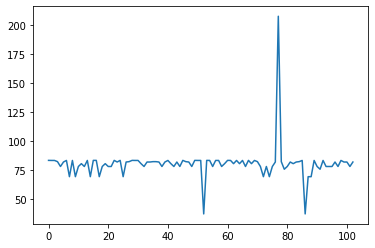

In [ ]:
plt.plot(losses)
plt.show()

### Простая вероятностная стратегия для всех состояний

In [197]:
import numpy as np
import random

state_n = 49
action_n = 2

class RandomAgent():
    def __init__(self, action_n):
        self.action_n = action_n
        return None
    
    def get_action(self, state):
        return random.randint(0, self.action_n - 1)

In [198]:
class CEM():
    def __init__(self, state_n, action_n):
        self.state_n = state_n
        self.action_n = action_n
        self.policy = np.ones((self.state_n, self.action_n)) / self.action_n
    
    def get_action(self, state):
        return int(np.random.choice(np.arange(self.action_n), p=self.policy[state]))
    
    def update_policy(self, elite_trajectories):
        pre_policy = np.zeros((self.state_n, self.action_n))
        
        for trajectory in elite_trajectories:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                pre_policy[state][action] += 1
                
        for state in range(self.state_n):
            if sum(pre_policy[state]) == 0:
                self.policy[state] = np.ones(self.action_n) / self.action_n
            else:
                self.policy[state] = pre_policy[state] / sum(pre_policy[state])
                
        return None

In [199]:
table = [0, 0]
customers = [5, 6]
costs = [3, 5]

In [216]:
list = ['1', '2', '3']
str_list = str(list)
type(int(''.join(list)))

int

In [218]:
str_list = [str(x) for x in list]

In [219]:
str_list

['1', '2', '3']

In [205]:
states = {'id' : [], 'state': []}
obs = [0, 0]

states['id'].append(0)
states['state'].append(obs)

In [209]:
obs = [0,1]

In [210]:
if obs in states['state']:
  print(obs)

In [200]:
# def get_state(obs):
#     return int(obs[1] * np.sqrt(state_n) + obs[0])

def get_state(obs):
  str_obs = [str(x) for x in obs]
  state = int(''.join(str_obs))
  return int(state)

def step(obs, action):
  done = False
  obs[action] += 1
  reward = np.sum(np.array(obs) * np.array(costs))
  if obs[0] == customers[0] or obs[1] == customers[1]:
    done = True
  if np.sum(obs) == 10:
    done = True
  return obs, reward, done

def reset():
  start_table = [0, 0]
  return start_table

def get_trajectory(agent, table, trajectory_len):
    trajectory = {'states': [], 'actions': [], 'total_reward': 0}
    states = {'id' : [], 'state': []}
    obs = [0, 0]
    state = get_state(obs)
    trajectory['states'].append(state)
    states['id'].append(0)
    states['states'].append(obs)
    for _ in range(trajectory_len):
      action = agent.get_action(state)
      trajectory['actions'].append(action)
      next_obs, reward, done = step(obs, action)
      state = get_state(next_obs)
      trajectory['total_reward'] += reward
      if done:
        print('Я закончил')
        break
      obs = next_obs
      trajectory['states'].append(state)
      print(trajectory)
    return trajectory


In [201]:
def get_elite_trajectories(trajectories, q_param):
    total_rewards = [trajectory['total_reward'] for trajectory in trajectories]
    quantile = np.quantile(total_rewards, q=q_param) 
    return [trajectory for trajectory in trajectories if trajectory['total_reward'] > quantile]

In [202]:
agent = CEM(state_n, action_n)
episode_n = 50
trajectory_n = 5
trajectory_len = 10
q_param = 0.9

for _ in range(episode_n):
    trajectories = [get_trajectory(agent, table, trajectory_len) for _ in range(trajectory_n)]
    
    mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
    print(mean_total_reward)
    
    elite_trajectories = get_elite_trajectories(trajectories, q_param)
    
    if len(elite_trajectories) > 0:
        agent.update_policy(elite_trajectories)

{'states': [0, 7], 'actions': [1], 'total_reward': 5}
{'states': [0, 7, 8], 'actions': [1, 0], 'total_reward': 13}
{'states': [0, 7, 8, 15], 'actions': [1, 0, 1], 'total_reward': 26}
{'states': [0, 7, 8, 15, 16], 'actions': [1, 0, 1, 0], 'total_reward': 42}
{'states': [0, 7, 8, 15, 16, 17], 'actions': [1, 0, 1, 0, 0], 'total_reward': 61}
{'states': [0, 7, 8, 15, 16, 17, 18], 'actions': [1, 0, 1, 0, 0, 0], 'total_reward': 83}
{'states': [0, 7, 8, 15, 16, 17, 18, 25], 'actions': [1, 0, 1, 0, 0, 0, 1], 'total_reward': 110}
{'states': [0, 7, 8, 15, 16, 17, 18, 25, 32], 'actions': [1, 0, 1, 0, 0, 0, 1, 1], 'total_reward': 142}
Я закончил
{'states': [0, 1], 'actions': [0], 'total_reward': 3}
{'states': [0, 1, 2], 'actions': [0, 0], 'total_reward': 9}
{'states': [0, 1, 2, 9], 'actions': [0, 0, 1], 'total_reward': 20}
{'states': [0, 1, 2, 9, 16], 'actions': [0, 0, 1, 1], 'total_reward': 36}
{'states': [0, 1, 2, 9, 16, 23], 'actions': [0, 0, 1, 1, 1], 'total_reward': 57}
{'states': [0, 1, 2, 9,

In [ ]:
[0, 0]
[1, 0]
[0, 1]
[1, 1]

In [182]:
a = [0, 1]

In [183]:
int(a[1] * 2 + a[0])

2

In [98]:
from traitlets.traitlets import observe
obs = reset()
state = get_state(obs)
print('Начальное состояние:', obs)
while True:
    action = agent.get_action(state)
    next_obs, reward, done = step(obs, action)
    state = get_state(next_obs)
    print('Следующее состояние', next_obs)
    for i in range(len(obs)):
      if obs[i] >= customers[i] or np.sum(obs) >= 40:
        print(obs[i], 'vs', customers[i], 'limit', np.sum(obs))
        continue
    if reward >= 260:
      print(reward)
      print(obs)
      break

    obs = next_obs

Начальное состояние: [0 0]


ValueError: ignored

In [ ]:
customers

[10, 20, 15, 5]

In [ ]:
print(obs)

[2, 3, 22, 3]


In [157]:
!pip install git+https://github.com/cair/gym-maze.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cair/gym-maze.git to /tmp/pip-req-build-qehhz6ti
  Running command git clone --filter=blob:none --quiet https://github.com/cair/gym-maze.git /tmp/pip-req-build-qehhz6ti
  Resolved https://github.com/cair/gym-maze.git to commit a6e1f01e1712fe5279f4b87f309269830864f8c2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 43.0 MB/s eta 0:00:00
  Created wheel for gym-maze: filename=gym_maze-2.0.0-py3-none-any.whl size=11323 sha256=9263ae047c7867f90f4cab9d5b617b730381d566208086ab34f6fb4e0022a022
  Stored in directory: /tmp/pip-ephem-wheel-cache-d2bwx9x0/wheels/6c/e0/cc/1a724ccbe7abd1d3297b552dace796d10b812e7ee9edda3489
Successfully built gym-maze


In [160]:
import gym
import gym_maze
import numpy as np
import random
import time

env = gym.make('Maze-5x5-POMDPMaze')
state_n = 25
action_n = 4


class RandomAgent():
    def __init__(self, action_n):
        self.action_n = action_n
        return None
    
    def get_action(self, state):
        return random.randint(0, self.action_n - 1)

class CEM():
    def __init__(self, state_n, action_n):
        self.state_n = state_n
        self.action_n = action_n
        self.policy = np.ones((self.state_n, self.action_n)) / self.action_n
    
    def get_action(self, state):
        return int(np.random.choice(np.arange(self.action_n), p=self.policy[state]))
    
    def update_policy(self, elite_trajectories):
        pre_policy = np.zeros((self.state_n, self.action_n))
        
        for trajectory in elite_trajectories:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                pre_policy[state][action] += 1
                
        for state in range(self.state_n):
            if sum(pre_policy[state]) == 0:
                self.policy[state] = np.ones(self.action_n) / self.action_n
            else:
                self.policy[state] = pre_policy[state] / sum(pre_policy[state])
                
        return None
                

def get_state(obs):
    return int(obs[1] * np.sqrt(state_n) + obs[0])

def get_trajectory(agent, trajectory_len):
    trajectory = {'states':[], 'actions': [], 'total_reward': 0}
    
    obs = env.reset()
    state = get_state(obs)
    trajectory['states'].append(state)
    
    for _ in range(trajectory_len):
        
        action = agent.get_action(state)
        trajectory['actions'].append(action)
        
        obs, reward, done, _ = env.step(action)
        state = get_state(obs)
        trajectory['total_reward'] += reward
        
        if done:
            break
            
        trajectory['states'].append(state)
            
    return trajectory

def get_elite_trajectories(trajectories, q_param):
    total_rewards = [trajectory['total_reward'] for trajectory in trajectories]
    quantile = np.quantile(total_rewards, q=q_param) 
    return [trajectory for trajectory in trajectories if trajectory['total_reward'] > quantile]


agent = CEM(state_n, action_n)
episode_n = 50
trajectory_n = 100
trajectory_len = 100
q_param = 0.9


for _ in range(episode_n):
    trajectories = [get_trajectory(agent, trajectory_len) for _ in range(trajectory_n)]
    
    mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
    print(mean_total_reward)
    
    elite_trajectories = get_elite_trajectories(trajectories, q_param)
    
    if len(elite_trajectories) > 0:
        agent.update_policy(elite_trajectories)

#test
obs = env.reset()
state = get_state(obs)

for _ in range(trajectory_len):

    action = agent.get_action(state)

    obs, reward, done, _ = env.step(action)
    state = get_state(obs)
    
    #env.render()
    time.sleep(0.5)

    if done:
        break

/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:601: UserWarning: WARN: Using the latest versioned environment `Maze-5x5-POMDPMaze-v0` instead of the unversioned environment `Maze-5x5-POMDPMaze`.
  logger.warn(


AssertionError: ignored